In [19]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [32]:
from open_atmos_jupyter_utils import show_plot
from open_atmos_jupyter_utils.show_anim import show_anim
from PyMPDATA import Options,ScalarField,VectorField,Solver,Stepper
from matplotlib import colors
from PyMPDATA.boundary_conditions import Periodic
from PyMPDATA_examples.Jaruga_et_al_2015.temp import *
import numpy as np
import matplotlib.pyplot as plt
from time import time
from numba import njit

In [33]:
#@njit
def vip_rhs_apply(dt,vip_rhs, advectee : np):
     for k in range(2):
         solvers[k].advectee.get()[:] += 0.5 * dt * vip_rhs[k]
         vip_rhs[k][:] = 0
#@njit
def calc_gc_extrapolate_in_time(solvers, stash):
    for k in ('u', 'w'):
        stash[k].get()[:] = -.5 * stash[k].get() + 1.5 * solvers[k].advectee.get()
        stash[k].get()[:] = -.5 * stash[k].get() + 1.5 * solvers[k].advectee.get()
        xchng_pres(stash[k])   
#@njit
def calc_gc_interpolate_in_space(advector: VectorField, stash: dict, dt:float, dxy: tuple):
    idx_diff = ( 
        (slice(None, -1), slice(None, None)),
        (slice(None, None), slice(None, -1)),
    )
    for axis, psi in enumerate(('u', 'w')):
        advector.data[axis][:] = dt / dxy[axis] * (
            np.diff(stash[psi].data, axis=axis) / 2 + stash[psi].data[idx_diff[axis]]
        )[:]
#@njit
def fill_stash(solvers, stash):
    for k in stash.keys():
        stash[k].get()[:] = solvers[k].advectee.get()
        xchng(stash[k].data, h=2)
#@njit
def apply_rhs(w, rhs_w : np.ndarray, dt : float):
    w += rhs_w * dt #same behaviour in step 1 observed in rhs_w as in libmpdata++
#@njit
def ini_pressure(Phi, solvers, N, M):
    npoints = N*M
    for k in ('u', 'w'):
        Phi.get()[:] -= 0.5 * np.power(solvers[k].advectee.get()[:],2)
    Phi_mean = np.sum(Phi.get()) / npoints
    Phi.get()[:] -= Phi_mean
@njit
def xchng(data, h):
    data[0:h,:] = data[-2*h:-h,:]
    data[-h:,:] = data[h:2*h,:]
    data[:,0:h] = data[:,-2*h:-h]
    data[:,-h:] = data[:,h:2*h]
#@njit
def xchng_pres(Phi):
    xchng(h = Phi.halo, data=Phi.data)
#@njit
#TODO: check at with libmpdata++
def update_rhs(tht : np.ndarray, rhs_w : np.ndarray, tht_ref : int, g : float):

    rhs_w[:] = 0
    rhs_w[:] += g * (tht - tht_ref) / tht_ref
#@njit    
def div(lap_tmp,dxy):
    h = lap_tmp['u'].halo
    return (
        np.gradient(lap_tmp['u'].data, dxy[0],axis=0) +
        np.gradient(lap_tmp['w'].data, dxy[1],axis=1)
    )[h:-h,h:-h]
#@njit
def lap(Phi, dxy, err_init, lap_tmp,tmp_uvw = None):
    xchng_pres(Phi)
    calc_grad(lap_tmp, Phi, dxy);
    if (err_init):
        for k in ('u', 'w'):
            lap_tmp[k].get()[:] -= tmp_uvw[k].get()

    for k in ('u', 'w'):
        xchng_pres(lap_tmp[k])
        
    return div(lap_tmp, dxy)
#@njit
def pressure_solver_loop_init(err,p_err,lap_p_err,dxy,lap_tmp,tmp_uvw):
    p_err[0].get()[:] = err.get()[:]
    lap_p_err[0][:] = lap(p_err[0], dxy, False, lap_tmp,tmp_uvw)
##@njit
def pressure_solver_loop_body(Phi,beta,converged,err,p_err,lap_p_err,dxy,k_iters,err_tol,lap_err,lap_tmp):
    tmp_den = [1.]*k_iters
    alpha = [1.]*k_iters
    for v in range(0,k_iters):

          tmp_den[v] = np.sum(lap_p_err[v]**2)
          if (tmp_den[v] != 0):
              beta = - np.dot(
                  err.get().ravel(),
                  lap_p_err[v].ravel()
              ) / tmp_den[v]
          Phi.get()[:] += beta * p_err[v].get()
          err.get()[:] += beta * lap_p_err[v]

          error = max(
             abs(np.amax(err.get())),
             abs(np.amin(err.get()))
          )

          if (error <= err_tol): 
              converged = True

          lap_err[:] = lap(err, dxy, False, lap_tmp);
          
          for l in range(v):
              if (tmp_den[l] != 0):
                    alpha[l] = - np.dot(lap_err.ravel(), lap_p_err[l].ravel()) / tmp_den[l];
          if (v < (k_iters - 1)):
              p_err[v + 1].get()[:] = err.get()
              lap_p_err[v + 1][:] = lap_err[:]
              for l in range(v):
                  p_err[v + 1].get()[:] += alpha[l] * p_err[l].get()
                  lap_p_err[v + 1][:] += alpha[l] * lap_p_err[l]
          else:
              p_err[0].get()[:] = err.get()[:] + alpha[0] * p_err[0].get()
              lap_p_err[0][:] = lap_err[:] + alpha[0] * lap_p_err[0]
              for l in range(1,v+1):
                    p_err[0].get()[:] += alpha[l] * p_err[l].get()
                    lap_p_err[0][:] += alpha[l] * lap_p_err[l]
    return converged


#@njit
def pressure_solver_update(solvers,Phi,beta,lap_tmp,tmp_uvw,err,p_err,lap_p_err,dxy,k_iters,err_tol,lap_err,simple = False):
    for k in ('u', 'w'):
         tmp_uvw[k].get()[:] = solvers[k].advectee.get()
    
    #initial error
    err.get()[:] = lap(Phi, dxy, True,lap_tmp,tmp_uvw)

    iters = 0
    converged = False

    pressure_solver_loop_init(err,p_err,lap_p_err,dxy,lap_tmp,tmp_uvw)
    #pseudo-time loop
    while not converged:        
         converged = pressure_solver_loop_body(Phi,beta,converged,err,p_err,lap_p_err,dxy,k_iters,err_tol,lap_err,lap_tmp)
         iters += 1

         if (iters > 10000): # going beyond 10000 iters means something is really wrong,
             # usually boundary conditions but not always !
             raise Exception("stuck in pressure solver")

    xchng_pres(Phi)

    calc_grad(tmp_uvw, Phi, dxy)

#@njit
def pressure_solver_apply(solvers,tmp_uvw):
    for k in ('u', 'w'):
        solvers[k].advectee.get()[:] -= tmp_uvw[k].get()

#@njit
def calc_grad(arg : ScalarField, Phi, dxy):
    h = Phi.halo
    idx = (slice(h,-h),slice(h,-h))
    arg['u'].get()[:] = np.gradient(Phi.data,dxy[0],axis = 0)[idx]
    arg['w'].get()[:] = np.gradient(Phi.data,dxy[1],axis = 1)[idx]

In [66]:

outfreq = 1

np.set_printoptions(linewidth=300, precision=3)
start0 = time()
N, M  = 20, 20
dxy = 2000/(N), 2000/(M)
Tht_ref = 300.
g = 9.81
r0 = 250.
dt = 7.5
nt = int(600//dt)
assert dt * nt == 600
beta  = 0.25
options = Options(n_iters=2, infinite_gauge= True,nonoscillatory = True)
mesh = np.full((N,M), fill_value=Tht_ref, dtype=float)
prs_tol = 1e-7;
err_tol = prs_tol/dt
output = []
k_iters = 4
xi, yi = np.indices((N, M))
mask = np.sqrt(((xi+1/2)*dxy[0]-1000)**2+((yi+1/2)*dxy[1]-260)**2) < r0
mesh += np.where(mask, 0.5, 0)
halo = options.n_halo
bcond = (Periodic(), Periodic())

field_ctor_kwargs = {'halo': halo, 'boundary_conditions': bcond}

def new_sf(N,M):
    return ScalarField(data=np.zeros((N,M)), **field_ctor_kwargs)

advector = VectorField(data=(np.zeros((N+1, M)), np.zeros((N, M+1))), **field_ctor_kwargs)
stepper = Stepper(options=options, grid=(N, M))

solver_ctor_kwargs = {'stepper': stepper, 'advector': advector}
solvers = {
    'tht': Solver(advectee=ScalarField(data=mesh, **field_ctor_kwargs), **solver_ctor_kwargs),
    'u': Solver(advectee=new_sf(N,M), **solver_ctor_kwargs),
    'w': Solver(advectee=new_sf(N,M), **solver_ctor_kwargs),
}
state_0 = solvers["tht"].advectee.get().copy()

#actual going forward

rhs_w = np.zeros((N,M))
stash = {k: new_sf(N,M) for k in ('u', 'w')}
vip_rhs = {'u': np.zeros((N,M)), 'w': np.zeros((N,M))}
Phi = new_sf(N,M)
tmp_uvw = {'u': new_sf(N,M), 'w': new_sf(N,M)}
lap_tmp = {'u': new_sf(N,M), 'w': new_sf(N,M)}
lap_err = np.zeros((N,M))
err = new_sf(N,M)
p_err = [new_sf(N,M) for _ in range(k_iters)]
lap_p_err = [np.empty((N,M)) for _ in range(k_iters)]
stop0 = time()
def debug(where):
    psi = vip_rhs['w']
    print(f"{where=} {np.amin(psi)=} {np.amax(psi)=}")
#action before loop
# correct initial velocity
start1 = time()
Phi.get()[:] = 0

pressure_solver_update(solvers,Phi,beta,lap_tmp,tmp_uvw,err,p_err,lap_p_err,dxy,k_iters,err_tol,lap_err,simple = True)

xchng_pres(Phi)
calc_grad(tmp_uvw, Phi, dxy)
pressure_solver_apply(solvers,tmp_uvw)
# potential pressure
ini_pressure(Phi,solvers,N,M)
# allow pressure_solver_apply at the first time step
xchng_pres(Phi)
calc_grad(tmp_uvw, Phi, dxy)
for k in ('u', 'w'):
     vip_rhs[k][:] -= tmp_uvw[k].get()
stop1 = time()
start2= time()
for step in range(nt + 1):
    if step != 0:
        calc_gc_extrapolate_in_time(solvers, stash) # reads & writes to stash
        calc_gc_interpolate_in_space(advector, stash,dt,dxy) # reads from stash
        fill_stash(solvers, stash) # writes to stash
        apply_rhs(solvers["w"].advectee.get(), rhs_w, dt/2)

        vip_rhs_apply(dt,vip_rhs, solvers)

        for solver in solvers.values():
            solver.advance(n_steps=1)

        update_rhs(tht=solvers["tht"].advectee.get(), rhs_w=rhs_w, g=g, tht_ref=Tht_ref)
        apply_rhs(solvers["w"].advectee.get(), rhs_w, dt/2)

        for k in ('u', 'w'):
            vip_rhs[k][:] = -solvers[k].advectee.get()
        pressure_solver_update(solvers,Phi,beta,lap_tmp,tmp_uvw,err,p_err,lap_p_err,dxy,k_iters,err_tol,lap_err)
        pressure_solver_apply(solvers,tmp_uvw)

        for k in ('u', 'w'):
            vip_rhs[k][:] += solvers[k].advectee.get()
            vip_rhs[k][:] /= 0.5 * dt
        
    if step % outfreq == 0:
        output.append(solvers["tht"].advectee.get().copy())
    print(step)
with open("output.npy", 'wb') as f:
    np.save(f,np.array(output))
stop2 = time()
print("initialization time:"+str(stop0-start0))
print("ante loop time:"+str(stop1-start1))
print("calculation time:"+str(stop2-start1))
print("total time: "+str(stop2-start0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
initialization time:0.007805824279785156
ante loop time:0.004880428314208984
calculation time:10.537868738174438
total time: 10.545674562454224


In [79]:
def plot(step):
    fig = plt.figure(figsize=(4,4))
    data = output[step]
    plt.title("(t/dt="+str(step)+")")
    plt.xlabel("x/dx")
    plt.ylabel("y/dy")
    grid = data.shape
    x,y = np.indices(grid)
    colorticks = np.linspace(299.95, 300.55, 7, endpoint=True)
    cmap = colors.ListedColormap(["white", "purple", "blue", "green","orange","yellow"])
    plt.contour(x+1/2,y+1/2,data, levels=colorticks[1:], colors='k')
    plt.imshow(data.T, origin="lower", extent=(0, grid[0], 0, grid[1]), cmap=cmap, vmin=colorticks[0], vmax=colorticks[-1])
    plt.colorbar(ticks=colorticks)
    return fig


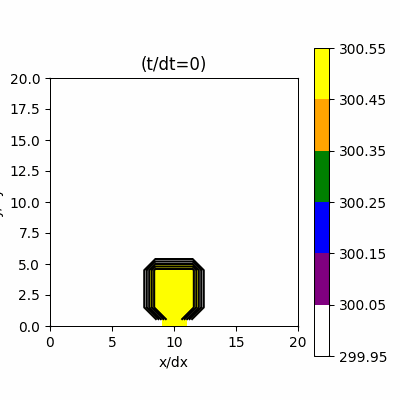

HTML(value="<a href='.\\tmpxwbt6wpl.gif' target='_blank'>.\\tmpxwbt6wpl.gif</a><br>")

In [80]:
show_anim(plot,frame_range=range(81))

In [56]:
print(output[1].shape)

(20, 20)


In [83]:
z = {k: new_sf(N,M) for k in ('u', 'w')}
y = np.array(z)
print(y)
print(z)

{'u': <PyMPDATA.scalar_field.ScalarField object at 0x00000146EDD7FEF0>, 'w': <PyMPDATA.scalar_field.ScalarField object at 0x00000146F832DDC0>}
{'u': <PyMPDATA.scalar_field.ScalarField object at 0x00000146EDD7FEF0>, 'w': <PyMPDATA.scalar_field.ScalarField object at 0x00000146F832DDC0>}
